In [1]:
!pip install l5kit
!pip install -U PyYAML

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 133kB 6.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 42.9MB 151kB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 5.8MB 11.9MB/s 
  Created wheel for pymap3d: filename=pymap3d-2.4.3-cp36-none-any.whl size=33551 sha256=805a4be5e4203ddbc557758a1c2645eac67118060ed7d5ccc2a589e57ee03b52
  Stored in directory: /root/.cache/pip/wheels/be/e2/40/c642184272827b886ddb12661008199fe1460d4b05ddfc2670
Successfully built pymap3d
  Created wheel for ptable: filename=PTable-0.9.2-cp36-none-any.whl size=22905 sha256=a4701dfd8db67c183bb97cd2d1b451e4e494adb04103858da76458680ba06b38
  Stored in directory: /root/.cache/pip/wheels/22/cc/2e/55980bfe86393df3e9896146a01f6802978d09d7ebcba5ea56
  Created wheel for transforms3d: filename=transforms3

In [2]:
!mkdir /root/.kaggle/
!touch /root/.kaggle/kaggle.json
!echo '{"username":"simarkareer","key":"ff816530aeb5eda4d7ce160a471cbe14"}' >> /root/.kaggle/kaggle.json
!cat /root/.kaggle/kaggle.json
!mkdir lyftdataset
!cd lyftdataset
!pip install --upgrade --force-reinstall --no-deps kaggle
!kaggle --version
!kaggle competitions download -c lyft-motion-prediction-autonomous-vehicles -p /content/lyftdataset/

{"username":"simarkareer","key":"ff816530aeb5eda4d7ce160a471cbe14"}
     |████████████████████████████████| 61kB 2.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.9-cp36-none-any.whl size=73265 sha256=d75053b799002e414c37dd94a4649cfc9aae2e11de58e71ee29516791ea2cf66
  Stored in directory: /root/.cache/pip/wheels/68/6d/9b/7a98271454edcba3b56328cbc78c037286e787d004c8afee71
Successfully built kaggle
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9
Kaggle API 1.5.9
100% 18.2G/18.3G [02:39<00:00, 170MB/s]
100% 18.3G/18.3G [02:39<00:00, 123MB/s]


In [3]:
%cd lyftdataset
!unzip -q lyft-motion-prediction-autonomous-vehicles.zip

/content/lyftdataset


In [70]:
!wget https://raw.githubusercontent.com/lyft/l5kit/master/examples/agent_motion_prediction/agent_motion_config.yaml

--2020-11-17 22:48:42--  https://raw.githubusercontent.com/lyft/l5kit/master/examples/agent_motion_prediction/agent_motion_config.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1592 (1.6K) [text/plain]
Saving to: ‘agent_motion_config.yaml’

agent_motion_config 100%[===================>]   1.55K  --.-KB/s    in 0s      

2020-11-17 22:48:42 (22.7 MB/s) - ‘agent_motion_config.yaml’ saved [1592/1592]



In [5]:
    # Make sure you are in /content/lyftdataset
!pwd
# %cd lyftdataset

/content/lyftdataset


In [71]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

In [ ]:
class EgoNeighborDataset(EgoDataset):
    def get_frame(self, scene_index: int, state_index: int, track_id: Optional[int] = None) -> dict:
        """
        A utility function to get the rasterisation and trajectory target for a given agent in a given frame
        Args:
            scene_index (int): the index of the scene in the zarr
            state_index (int): a relative frame index in the scene
            track_id (Optional[int]): the agent to rasterize or None for the AV
        Returns:
            dict: the rasterised image in (Cx0x1) if the rast is not None, the target trajectory
            (position and yaw) along with their availability, the 2D matrix to center that agent,
            the agent track (-1 if ego) and the timestamp
        """
        frames = self.dataset.frames[get_frames_slice_from_scenes(self.dataset.scenes[scene_index])]

        tl_faces = self.dataset.tl_faces
        try:
            if self.cfg["raster_params"]["disable_traffic_light_faces"]:
                tl_faces = np.empty(0, dtype=self.dataset.tl_faces.dtype)  # completely disable traffic light faces
        except KeyError:
            warnings.warn(
                "disable_traffic_light_faces not found in config, this will raise an error in the future",
                RuntimeWarning,
                stacklevel=2,
            )
        data = self.sample_function(state_index, frames, self.dataset.agents, tl_faces, track_id)

        # add information only, so that all data keys are always preserved
        data["host_id"] = self.dataset.scenes[scene_index]["host"]
        data["timestamp"] = frames[state_index]["timestamp"]
        data["track_id"] = np.int64(-1 if track_id is None else track_id)  # always a number to avoid crashing torch
        data["world_to_image"] = data["raster_from_world"]  # TODO deprecate
        data[""]

        # when rast is None, image could be None. In that case we remove the key
        if data["image"] is not None:
            data["image"] = data["image"].transpose(2, 0, 1)  # 0,1,C -> C,0,1
        else:
            del data["image"]

        return data

## Prepare Data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [77]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/content/lyftdataset"
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./agent_motion_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False}, 'train_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': True, 'num_workers': 16}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 5, 'eval_every_n_steps': 10000}}


## Model

Our baseline is a simple `resnet50` pretrained on `imagenet`. We must replace the input and the final layer to address our requirements.

In [78]:
def build_model(cfg: Dict) -> torch.nn.Module:
    # load pre-trained Conv2D model
    model = resnet50(pretrained=True)

    # change input channels number to match the rasterizer's output
    num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
    num_in_channels = 3 + num_history_channels
    model.conv1 = nn.Conv2d(
        num_in_channels,
        model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=False,
    )
    # change output size to (X, Y) * number of future states
    num_targets = 2 * cfg["model_params"]["future_num_frames"]
    model.fc = nn.Linear(in_features=2048, out_features=num_targets)

    return model

In [83]:
def forward(data, model, device, criterion):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    print("")
    print("-"*100)
    print(data["target_positions"].shape)
    print(data["target_positions"])
    print(data["history_positions"].shape)
    print(data["history_positions"])
    print(data["track_id"])
    print("-"*100)
    targets = data["target_positions"].to(device)
    # Forward pass
    outputs = model(inputs).reshape(targets.shape)
    loss = criterion(outputs, targets)
    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = loss * target_availabilities
    loss = loss.mean()
    return loss, outputs

## Load the Train Data

Our data pipeline map a raw `.zarr` folder into a multi-processing instance ready for training by:
- loading the `zarr` into a `ChunkedDataset` object. This object has a reference to the different arrays into the zarr (e.g. agents and traffic lights);
- wrapping the `ChunkedDataset` into an `AgentDataset`, which inherits from torch `Dataset` class;
- passing the `AgentDataset` into a torch `DataLoader`

In [84]:
# ===== INIT DATASET
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [85]:
# ==== INIT MODEL
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = build_model(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction="none")

# Training

note: if you're on MacOS and using `py_satellite` rasterizer, you may need to disable opencv multiprocessing by adding:
`cv2.setNumThreads(0)` before the following cell. This seems to only affect running in python notebook and it's caused by the `cv2.warpaffine` function

In [86]:
# ==== TRAIN LOOP
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
losses_train = []
for _ in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    model.train()
    torch.set_grad_enabled(True)
    loss, _ = forward(data, model, device, criterion)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")


  0%|          | 0/5 [00:00<?, ?it/s]


----------------------------------------------------------------------------------------------------
torch.Size([12, 50, 2])
tensor([[[ 1.1908e+00,  3.6921e-02],
         [ 2.3340e+00,  3.7045e-02],
         [ 3.5007e+00,  5.3522e-02],
         ...,
         [ 6.0491e+01, -1.4975e+00],
         [ 6.1845e+01, -1.5986e+00],
         [ 6.3184e+01, -1.6908e+00]],

        [[ 1.5653e-02,  2.3646e-02],
         [ 2.4958e-02,  5.4912e-02],
         [ 4.6114e-02,  5.8069e-02],
         ...,
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]],

        [[ 1.1132e+00, -6.4348e-02],
         [ 2.2283e+00, -6.2176e-02],
         [ 3.3556e+00, -1.0957e-01],
         ...,
         [ 4.6921e+01, -6.6128e+00],
         [ 4.7771e+01, -6.9524e+00],
         [ 4.8626e+01, -7.3401e+00]],

        ...,

        [[-9.3180e-03, -6.6621e-03],
         [-1.6130e-02, -3.9831e-02],
         [-3.9592e-02, -3.8307e-02],
         ...,
         [-2.2471e-01


loss: 138.8378143310547 loss(avg): 138.8378143310547:   0%|          | 0/5 [00:23<?, ?it/s]
loss: 138.8378143310547 loss(avg): 138.8378143310547:  20%|██        | 1/5 [00:23<01:33, 23.30s/it]


----------------------------------------------------------------------------------------------------
torch.Size([12, 50, 2])
tensor([[[ 1.7774e+00, -2.5168e-03],
         [ 3.5870e+00, -3.0729e-02],
         [ 5.4042e+00, -6.1114e-02],
         ...,
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]],

        [[ 1.3509e-03,  1.0626e-03],
         [ 4.5911e-03, -3.5336e-03],
         [ 6.1667e-03, -6.5078e-03],
         ...,
         [ 7.7413e-01,  7.9716e-03],
         [ 8.4739e-01,  7.2740e-03],
         [ 8.8269e-01, -1.0730e-03]],

        [[-4.7135e-03,  2.3830e-02],
         [-2.5482e-04,  1.0099e-02],
         [ 0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]],

        ...,

        [[ 6.6307e-01,  8.3141e-03],
         [ 1.2999e+00,  1.4040e-02],
         [ 1.9590e+00,  2.2097e-03],
         ...,
         [ 1.6950e+01


loss: 9.6594877243042 loss(avg): 74.24865102767944:  20%|██        | 1/5 [00:32<01:33, 23.30s/it]  
loss: 9.6594877243042 loss(avg): 74.24865102767944:  40%|████      | 2/5 [00:32<00:57, 19.15s/it]


----------------------------------------------------------------------------------------------------
torch.Size([12, 50, 2])
tensor([[[-5.2397e-03,  2.0079e-03],
         [-1.2278e-02,  1.8780e-02],
         [-1.4060e-02,  2.6050e-02],
         ...,
         [-1.1919e-01,  2.2587e-02],
         [-1.0106e-01,  2.7084e-02],
         [-8.5606e-02,  2.2607e-02]],

        [[ 7.9229e-01,  2.5864e-02],
         [ 1.5391e+00,  9.5583e-02],
         [ 2.4268e+00,  1.2816e-01],
         ...,
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]],

        [[ 1.2542e-02,  8.8519e-03],
         [-1.9120e-03,  1.6054e-02],
         [-2.7777e-02,  2.9819e-02],
         ...,
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]],

        ...,

        [[ 1.2296e+00, -4.8315e-03],
         [ 2.4468e+00, -6.0539e-03],
         [ 3.7914e+00,  3.9759e-03],
         ...,
         [ 6.0091e+01


loss: 89.42937469482422 loss(avg): 79.30889225006104:  40%|████      | 2/5 [00:41<00:57, 19.15s/it]
loss: 89.42937469482422 loss(avg): 79.30889225006104:  60%|██████    | 3/5 [00:41<00:32, 16.14s/it]


----------------------------------------------------------------------------------------------------
torch.Size([12, 50, 2])
tensor([[[ 1.5498e-03, -2.0446e-04],
         [-9.4444e-04, -2.5675e-03],
         [-1.0012e-03, -1.1755e-03],
         ...,
         [-4.5106e-02,  6.6734e-02],
         [-4.5350e-02,  6.7728e-02],
         [-1.9314e-02,  6.6774e-02]],

        [[-1.1127e-01, -8.2759e-04],
         [-1.7301e-01, -3.4810e-02],
         [-1.9524e-01, -4.3863e-02],
         ...,
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]],

        [[ 4.0498e-01,  6.2706e-02],
         [ 8.7033e-01,  1.1211e-01],
         [ 1.2888e+00,  1.5341e-01],
         ...,
         [ 2.6761e+01,  1.0910e+01],
         [ 2.7414e+01,  1.1311e+01],
         [ 2.8087e+01,  1.1684e+01]],

        ...,

        [[ 1.5793e+00, -3.0328e-02],
         [ 3.2205e+00, -6.3348e-02],
         [ 4.7315e+00, -7.9903e-02],
         ...,
         [ 0.0000e+00


loss: 82.22737121582031 loss(avg): 80.03851199150085:  60%|██████    | 3/5 [00:51<00:32, 16.14s/it]
loss: 82.22737121582031 loss(avg): 80.03851199150085:  80%|████████  | 4/5 [00:51<00:14, 14.04s/it]


----------------------------------------------------------------------------------------------------
torch.Size([12, 50, 2])
tensor([[[-4.2461e-02,  7.0536e-04],
         [-6.9416e-02, -8.4467e-03],
         [-8.6007e-02, -6.9298e-03],
         ...,
         [-9.2704e-02,  2.1140e-02],
         [-1.0724e-01,  1.4976e-02],
         [-5.1174e-02,  5.1590e-03]],

        [[-1.4361e-02,  1.0062e-03],
         [-2.8813e-02, -6.1325e-03],
         [-2.6015e-02, -8.7128e-03],
         ...,
         [ 7.0672e-02,  4.0331e-01],
         [ 6.9203e-02,  3.9812e-01],
         [ 0.0000e+00,  0.0000e+00]],

        [[ 3.0923e-02,  1.8298e-02],
         [ 5.9123e-02,  4.3927e-02],
         [ 7.1932e-02,  3.8558e-02],
         ...,
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]],

        ...,

        [[ 1.5133e-01, -2.2150e-02],
         [ 3.0135e-01, -1.0178e-02],
         [ 3.3554e-01, -3.5776e-02],
         ...,
         [ 1.3797e+00


loss: 89.17884826660156 loss(avg): 81.866579246521:  80%|████████  | 4/5 [01:00<00:14, 14.04s/it]  
loss: 89.17884826660156 loss(avg): 81.866579246521: 100%|██████████| 5/5 [01:00<00:00, 12.05s/it]


### Plot Loss Curve
We can plot the train loss against the iterations (batch-wise)

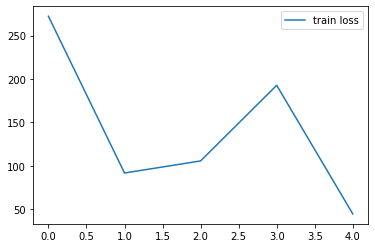

In [ ]:
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
plt.legend()
plt.show()

# Evaluation

Evaluation follows a slightly different protocol than training. When working with time series, we must be absolutely sure to avoid leaking the future in the data.

If we followed the same protocol of training, one could just read ahead in the `.zarr` and forge a perfect solution at run-time, even for a private test set.

As such, **the private test set for the competition has been "chopped" using the `chop_dataset` function**.

In [ ]:
# ===== GENERATE AND LOAD CHOPPED DATASET
num_frames_to_chop = 100
eval_cfg = cfg["val_data_loader"]
eval_base_path = create_chopped_dataset(dm.require(eval_cfg["key"]), cfg["raster_params"]["filter_agents_threshold"], 
                              num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)

copying: 100%|██████████| 100/100 [00:02<00:00, 43.81it/s]
/usr/local/lib/python3.6/dist-packages/l5kit/evaluation/extract_ground_truth.py:59: RuntimeWarning: you're running with a custom agents_mask
  dataset = AgentDataset(cfg=cfg, zarr_dataset=zarr_dataset, rasterizer=rasterizer, agents_mask=agents_mask)
extracting GT: 100%|██████████| 480/480 [00:05<00:00, 85.06it/s]


The result is that **each scene has been reduced to only 100 frames**, and **only valid agents in the 100th frame will be used to compute the metrics**. Because following frames in the scene have been chopped off, we can't just look ahead to get the future of those agents.

In this example, we simulate this pipeline by running `chop_dataset` on the validation set. The function stores:
- a new chopped `.zarr` dataset, in which each scene has only the first 100 frames;
- a numpy mask array where only valid agents in the 100th frame are True;
- a ground-truth file with the future coordinates of those agents;

Please note how the total number of frames is now equal to the number of scenes multipled by `num_frames_to_chop`. 

The remaining frames in the scene have been sucessfully chopped off from the data

In [ ]:
eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(eval_cfg["key"])).name)
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
eval_gt_path = str(Path(eval_base_path) / "gt.csv")

eval_zarr = ChunkedDataset(eval_zarr_path).open()
eval_mask = np.load(eval_mask_path)["arr_0"]
# ===== INIT DATASET AND LOAD MASK
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   10000    |   751440   |     130740    |       0.28      |        100.00        |        75.14         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: you're running with a custom agents_mask
  


### Storing Predictions
There is a small catch to be aware of when saving the model predictions. The output of the models are coordinates in `agent` space and we need to convert them into displacements in `world` space.

To do so, we first convert them back into the `world` space and we then subtract the centroid coordinates.

In [ ]:
# ==== EVAL LOOP
model.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []
agent_ids = []

progress_bar = tqdm(eval_dataloader)
for data in progress_bar:
    _, ouputs = forward(data, model, device, criterion)
    
    # convert agent coordinates into world offsets
    agents_coords = ouputs.cpu().numpy()
    world_from_agents = data["world_from_agent"].numpy()
    centroids = data["centroid"].numpy()
    coords_offset = []
    
    for agent_coords, world_from_agent, centroid in zip(agents_coords, world_from_agents, centroids):
        coords_offset.append(transform_points(agent_coords, world_from_agent) - centroid[:2])
    
    future_coords_offsets_pd.append(np.stack(coords_offset))
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy())
    

100%|██████████| 40/40 [01:42<00:00,  2.57s/it]


### Save results
After the model has predicted trajectories for our evaluation set, we can save them in a `csv` file.

During the competition, only the `.zarr` and the mask will be provided for the private test set evaluation.
Your solution is expected to generate a csv file which will be compared to the ground truth one on a separate server

In [ ]:
pred_path = f"{gettempdir()}/pred.csv"

write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
              )

In [ ]:
print(pred_path)

/tmp/pred.csv


### Perform Evaluation
Pleae note that our metric supports multi-modal predictions (i.e. multiple predictions for a single GT trajectory). In that case, you will need to provide a confidence for each prediction (confidences must all be between 0 and 1 and sum to 1).

In this simple example we don't generate multiple trajectories, so we won't pass any confidences vector. Internally, the metric computation will assume a single trajectory with confidence equal to 1

In [ ]:
metrics = compute_metrics_csv(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)


neg_multi_log_likelihood 6945.711122537991
time_displace [ 0.37570117  0.97924535  1.33557152  1.80123027  2.19719568  2.45748163
  2.79770332  3.25033127  3.68260382  3.91370362  4.22196584  4.54516864
  4.8577963   5.22326749  5.73568502  5.91429726  6.18876793  6.53926024
  6.85184084  7.11096306  7.58585766  7.81595706  8.15171142  8.42744488
  8.57573505  8.89072123  9.35795588  9.40162156  9.76222114 10.05093265
 10.18309307 10.47685457 10.70122193 10.94711855 11.30380591 11.54689701
 11.8377796  11.9917542  12.32124427 12.46934795 12.81532656 13.0397646
 13.2381057  13.48542438 13.40805933 13.45250018 13.48172387 13.63129823
 13.71544061 13.94250968]


### Visualise Results
We can also visualise some results from the ego (AV) point of view for those frames of interest (the 100th of each scene).

However, as we chopped off the future from the dataset **we must use the GT csv if we want to plot the future trajectories of the agents**


In [ ]:
model.eval()
torch.set_grad_enabled(False)

# build a dict to retrieve future trajectories from GT
gt_rows = {}
for row in read_gt_csv(eval_gt_path):
    gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

eval_ego_dataset = EgoDataset(cfg, eval_dataset.dataset, rasterizer)

for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
    agent_indices = eval_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
    predicted_positions = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = eval_dataset[v_index]

        out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
        out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
        # store absolute world coordinates
        predicted_positions.append(transform_points(out_pos, data_agent["world_from_agent"]))
        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])

    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)

    plt.imshow(im_ego[::-1])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.